In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
#!unzip "/content/drive/MyDrive/chest_xray.zip"

In [4]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

image_size = (192, 192)
batch_size = 32

Since we have only two classes we can use binary classification (0 or 1).

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
    )

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    )
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


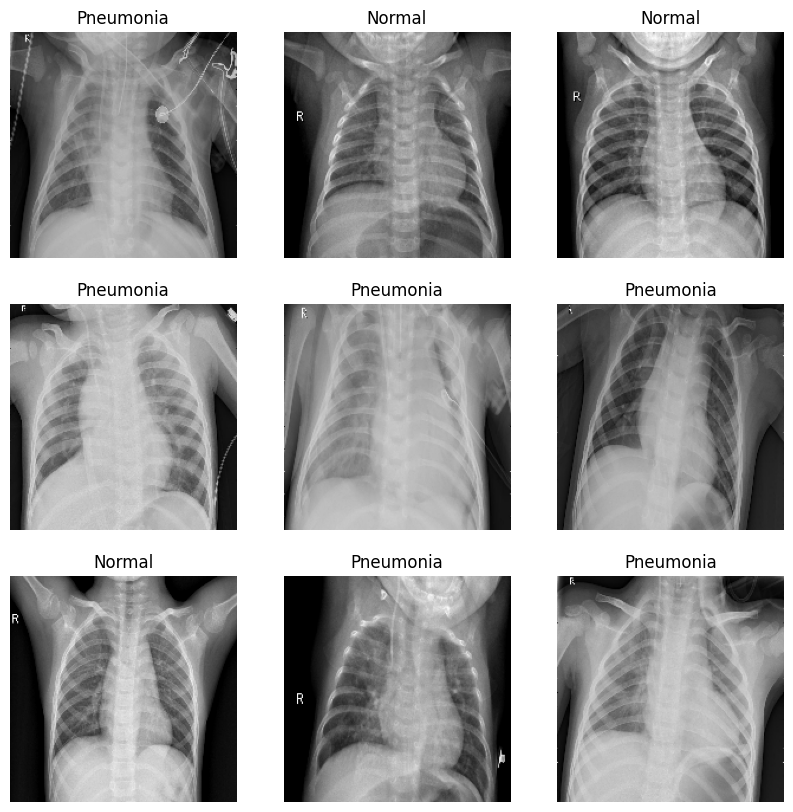

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title( "Pneumonia" if labels[i].numpy().astype("uint8") == 1 else "Normal")
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in test_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

for image_batch, labels_batch in val_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 192, 192, 3)
(32, 1)
(32, 192, 192, 3)
(32, 1)
(16, 192, 192, 3)
(16, 1)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.15),
])

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (192, 192, 3), include_top=False, weights = "imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
base_model.trainable = False

In [13]:
inputs = tf.keras.Input(shape = (192, 192, 3))

x = data_augmentation(inputs)
x = preprocess_input(inputs)

x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [15]:
base_learning_rate = 5e-5

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold = 0, name = "accuracy")])

In [16]:
history = model.fit(train_data, epochs = 30, validation_data = val_data, callbacks=[early_stopping])

Epoch 1/30
163/163 [==============================] - 48s 215ms/step - loss: 0.3131 - accuracy: 0.8681 - val_loss: 0.4785 - val_accuracy: 0.6875
Epoch 2/30
163/163 [==============================] - 37s 219ms/step - loss: 0.1595 - accuracy: 0.9415 - val_loss: 0.4482 - val_accuracy: 0.7500
Epoch 3/30
163/163 [==============================] - 35s 206ms/step - loss: 0.1295 - accuracy: 0.9513 - val_loss: 0.3875 - val_accuracy: 0.7500
Epoch 4/30
163/163 [==============================] - 37s 213ms/step - loss: 0.1129 - accuracy: 0.9569 - val_loss: 0.3829 - val_accuracy: 0.7500
Epoch 5/30
163/163 [==============================] - 35s 207ms/step - loss: 0.0996 - accuracy: 0.9638 - val_loss: 0.3571 - val_accuracy: 0.7500
Epoch 6/30
163/163 [==============================] - 37s 207ms/step - loss: 0.0930 - accuracy: 0.9653 - val_loss: 0.3554 - val_accuracy: 0.7500
Epoch 7/30
163/163 [==============================] - 35s 209ms/step - loss: 0.0895 - accuracy: 0.9663 - val_loss: 0.3935 - val_ac

In [17]:
results = model.evaluate(test_data)

20/20 [==============================] - 4s 114ms/step - loss: 0.4846 - accuracy: 0.8413


In [18]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 100),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name="accuracy")])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 192, 192, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 192, 192, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [27]:
fine_tune_epochs = 15
total_epochs =  history.epoch[-1] + 1 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1] + 1,
                         validation_data=val_data, callbacks=[early_stopping, plateau])

Epoch 20/34
163/163 [==============================] - 53s 246ms/step - loss: 0.0576 - accuracy: 0.9801 - val_loss: 0.3473 - val_accuracy: 0.7500 - lr: 5.0000e-07
Epoch 21/34
163/163 [==============================] - 39s 229ms/step - loss: 0.0529 - accuracy: 0.9810 - val_loss: 0.3460 - val_accuracy: 0.7500 - lr: 5.0000e-07
Epoch 22/34
163/163 [==============================] - 36s 212ms/step - loss: 0.0513 - accuracy: 0.9818 - val_loss: 0.3479 - val_accuracy: 0.7500 - lr: 5.0000e-07
Epoch 23/34
163/163 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9835
Epoch 23: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
163/163 [==============================] - 38s 222ms/step - loss: 0.0490 - accuracy: 0.9835 - val_loss: 0.3982 - val_accuracy: 0.7500 - lr: 5.0000e-07
Epoch 24/34
163/163 [==============================] - 38s 223ms/step - loss: 0.0474 - accuracy: 0.9845 - val_loss: 0.3265 - val_accuracy: 0.7500 - lr: 1.0000e-07
Epoch 25/34
163/163 [==

In [29]:
results = model.evaluate(test_data)

20/20 [==============================] - 3s 102ms/step - loss: 0.5815 - accuracy: 0.8317


In [30]:
y_predict = model.predict(test_data)

20/20 [==============================] - 5s 105ms/step


In [32]:
y_predict = (y_predict > 0).astype(int)

In [37]:
y_labels = np.concatenate([y for x, y in test_data], axis=0).astype(int)


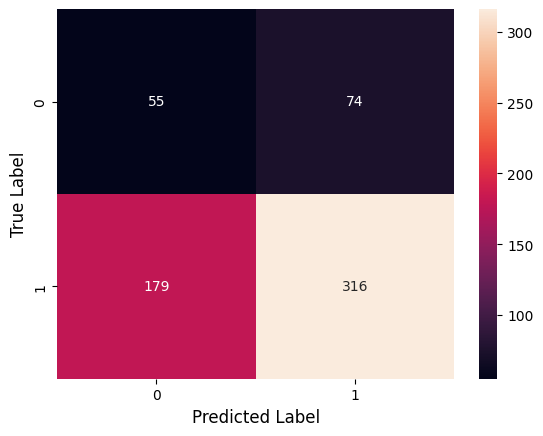

In [40]:
from sklearn import metrics
import seaborn

confusion_matrix = metrics.confusion_matrix(y_predict, y_labels)
seaborn.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()